In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
import re
import numpy as np
import pickle
import fasttext.util
import torch
from sklearn.decomposition import PCA
from random import sample
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import seaborn as sns

## Build Bigrams (No need to run again)

Let's compute the emebeddings for each word appearing in the tweets we analyze. First, let's load our tweeter data.

In [ ]:
tweets = pd.read_pickle('data/tweets.pkl.bz2', compression='bz2')
tweets.head()

Clean the tweets text from all unwanted characters.

In [ ]:
def clean_tweets(x):
    x = x.lower()
    x = x.replace('\n',' ')
    # remove @
    cleaned_string = re.sub("@[A-Za-z0-9_]+",'', x)
    # remove hashtag
    cleaned_string = re.sub("#","", cleaned_string)
    # remove url
    cleaned_string = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b','', str(cleaned_string), flags=re.MULTILINE)
    
    # remove emojis
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    cleaned_string = regrex_pattern.sub(r'',  cleaned_string)
        
        
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', cleaned_string)
    return cleaned_string

tqdm.pandas() 
text_clean = tweets['text'].progress_map(clean_tweets)

We can apply now the word tokenization.

In [ ]:
# cleaned text example
text_clean.head(2).values

In [ ]:
print('Tokenizing...')
tokenizer = RegexpTokenizer('[a-zA-Z0-9]\w+')
tokens = [tokenizer.tokenize(tweet) for tweet in tqdm(text_clean)]

In [ ]:
# token example
tokens[1][:10]

Now, let's load the model for word embedding. For this task, we use the `fasttext` model, the same model we use to perform document emeddings and use for classification of the winning pair in the BTM model.

In [ ]:
ft = fasttext.load_model('cc.en.300.bin')
ft.get_dimension()

We here first get all bi-grams

In [ ]:
dic_bigram = {}
word_out = []
from nltk.probability import FreqDist
fdist = FreqDist()

for ts in tqdm(tokens):
    bigrams = nltk.bigrams(ts)
    for ws in bigrams:
        try :
            # emb_1 = ft.get_word_vector(ws[0])
            # emb_2 = ft.get_word_vector(ws[1])
            # emb = (emb_1 + emb_2)/2
            # dic_bigram.update({ws : emb})
            fdist[ws] += 1
        except: 
            word_out = word_out.append(ws)
            continue
            
fdist

In [ ]:
# most common words
#fdist.most_common(20)
df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index.name = 'Term'
df_fdist

here we noticed that there are a lot of bi-gram only appear once, the 75 quantile of the frequency is 3.

In [ ]:
df_fdist.describe()

In [ ]:
df_fdist = df_fdist[df_fdist['Frequency'] > 10]
df_fdist

In [ ]:
dic_bigram = {}
word_out = []

for i in tqdm(df_fdist.index):
    try :
        emb_1 = ft.get_word_vector(i[0])
        emb_2 = ft.get_word_vector(i[1])
        emb = (emb_1 + emb_2)/2
        dic_bigram.update({i : emb})
           
    except: 
        word_out = word_out.append(i)
        continue

len(dic_bigram)


In [ ]:
# let's create a dictonary, so we can save it and re-use it latter
df_dict = pd.DataFrame.from_dict(dic_bigram, orient='index')
df_dict

In [ ]:
# add frequency column, so we can later sort out words that appear very rarely in our 
df_dict['frequency'] = df_dict.index.map(fdist)
df_dict

In [ ]:
# saving results, no need to re-run this part of the code anymore
df_dict.to_pickle('data/bigram.pkl.bz2',compression='bz2')

# Interpretation and results

Let's perform the interpretation of the results for each of our models. 

In [2]:
# load the dictionarly of bigrams properly embedded with fasttext model
word_dict = pd.read_pickle('data/bigram.pkl.bz2',compression='bz2')
word_dict.head(10)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,frequency
"(the, business)",-0.034616,0.047232,-0.006303,0.049580,-0.037124,0.042071,0.037814,-0.002660,-0.001415,0.005219,...,-0.017859,-0.035677,0.026899,-0.038411,-0.027634,-0.020967,0.142222,-0.010705,0.003219,5564
"(business, of)",-0.008780,-0.083620,-0.035300,-0.204408,-0.019865,0.037216,0.004973,0.034216,-0.006140,0.004440,...,0.002437,-0.061937,0.120499,-0.064099,-0.018699,-0.008504,0.037941,-0.080145,0.014343,1149
"(of, businesses)",-0.030593,-0.096034,-0.041795,-0.220057,-0.017181,0.040795,-0.013028,0.039685,-0.002545,-0.013907,...,0.019236,-0.053693,0.131681,-0.072086,-0.025792,0.008592,0.031430,-0.045575,0.029365,1043
"(businesses, is)",-0.079436,-0.106300,-0.058131,0.003559,-0.137406,0.012596,0.017852,0.060473,-0.008975,-0.037345,...,0.038968,-0.089727,0.097315,-0.050940,-0.000991,0.041656,-0.096886,-0.088577,0.064825,161
"(is, climate)",-0.079481,-0.126187,-0.025456,0.006256,-0.124971,-0.048428,0.064270,0.075826,-0.008035,-0.026921,...,0.020831,-0.118836,0.098124,-0.007620,0.021870,0.041255,-0.076068,-0.061457,0.047905,33796
"(climate, change)",-0.034347,-0.039277,0.078490,0.047445,-0.022131,-0.023462,0.092314,0.024673,0.051735,-0.019316,...,-0.005075,-0.049551,0.074609,0.021365,-0.000821,0.041503,0.050761,0.037718,0.028440,4719088
"(change, adaptation)",-0.018736,-0.007223,0.066286,0.028441,-0.000144,0.005253,0.050561,-0.010239,0.053462,0.006127,...,-0.008160,-0.034063,0.072368,-0.010441,-0.019427,0.030384,0.025892,-0.018993,0.017719,14750
"(adaptation, from)",-0.034380,0.157863,-0.019711,0.001635,0.012059,0.014865,0.040307,-0.001009,0.002814,0.004079,...,0.004501,-0.008467,0.036564,0.003671,-0.009068,-0.014267,0.009769,-0.011151,0.020644,95
"(from, title)",-0.049088,0.167979,-0.023331,0.028399,0.035417,0.021887,-0.006659,0.002779,-0.036251,0.011338,...,-0.026561,-0.006193,0.038557,-0.008408,-0.012532,-0.062685,0.015129,-0.058903,0.054946,5621
"(title, the)",-0.055570,0.057101,0.004053,0.044387,0.023339,0.020363,-0.022489,-0.012961,-0.034219,0.029997,...,-0.053343,-0.038780,0.038643,-0.046964,-0.033935,-0.063808,0.137019,-0.053477,0.024903,129852


## Inital BTM Model

Let's start with analyzing the reults of the inital BTM model.

In [3]:
class LogRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1, bias=False)
    
    def forward(self, x):
        return self.linear(x)
    
model = LogRegression(300)
model.load_state_dict(torch.load("Models/btm-inital-time10%.pth"))
model.eval()

for p in model.parameters():
    print("Learned weights shape:", p.shape)
    weights = p
    weights.requires_grad = False

Learned weights shape: torch.Size([1, 300])


Let's compute the significants scores for each word based on the weights of the initial BTM model.

In [4]:
scores = weights.numpy() @ (word_dict.iloc[:, :-1]).T
scores.shape

(1, 1468775)

In [5]:
word_dict['init_scores'] = scores.squeeze(0)
word_dict.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,frequency,init_scores
"(surface, oceans)",-0.046731,0.003369,-0.000477,0.014830,0.013907,-0.086063,0.010847,0.019249,-0.012384,-0.030830,...,-0.095596,-0.051033,0.045794,0.043755,-0.077242,0.081081,0.015637,0.019985,46,2.606662
"(change, jack)",0.070283,-0.010072,0.128426,0.100837,-0.039758,0.001832,0.019754,-0.007679,0.036351,-0.014042,...,-0.219975,0.114395,-0.047333,-0.041436,-0.021596,0.066850,-0.070127,-0.029840,41,0.506270
"(york, off)",0.008527,0.042560,0.004912,0.033550,-0.040972,0.047350,0.092715,0.010782,-0.034311,0.033498,...,-0.278988,0.005197,-0.055589,0.078857,0.027878,0.154429,-0.048515,-0.085754,16,2.524971
"(services, however)",-0.017631,0.042626,-0.002195,0.011865,-0.031982,0.026149,0.012185,0.000893,-0.003010,-0.012988,...,-0.016866,0.013714,-0.000764,0.019508,0.008688,0.048310,-0.018476,0.006924,12,-0.662394
"(15, billion)",0.063483,0.119831,0.054865,-0.146150,0.087685,-0.010649,-0.114855,0.056285,-0.043449,-0.034187,...,-0.177902,-0.145109,0.016025,0.043741,0.016598,0.968751,0.074144,-0.097594,2771,1.726797


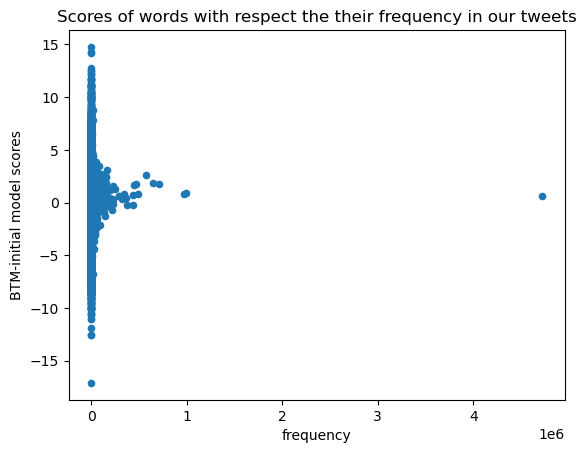

In [6]:
word_dict.plot.scatter(x="frequency", y="init_scores")
plt.ylabel("BTM-initial model scores")
plt.title("Scores of words with respect the their frequency in our tweets")
plt.show()

In [8]:
word_dict["frequency"].describe()

count    1.468775e+06
mean     1.590976e+02
std      4.546691e+03
min      1.100000e+01
25%      1.500000e+01
50%      2.600000e+01
75%      6.400000e+01
max      4.719088e+06
Name: frequency, dtype: float64

In [9]:
# the most frequent words
word_dict['frequency'].sort_values(ascending=False).head()

(climate, change)    4719088
(of, the)             995388
(in, the)             975919
(global, warming)     705732
(fossil, fuel)        644649
Name: frequency, dtype: int64

Here we only drop the frequent bigram that appear more than 100000 time.

In [10]:
word_dict_freq = word_dict[(word_dict['frequency'] < 1e5)][["frequency", "init_scores"]]
word_dict_freq["frequency"].describe()

count    1.468706e+06
mean     1.448520e+02
std      1.119635e+03
min      1.100000e+01
25%      1.500000e+01
50%      2.600000e+01
75%      6.400000e+01
max      9.939600e+04
Name: frequency, dtype: float64

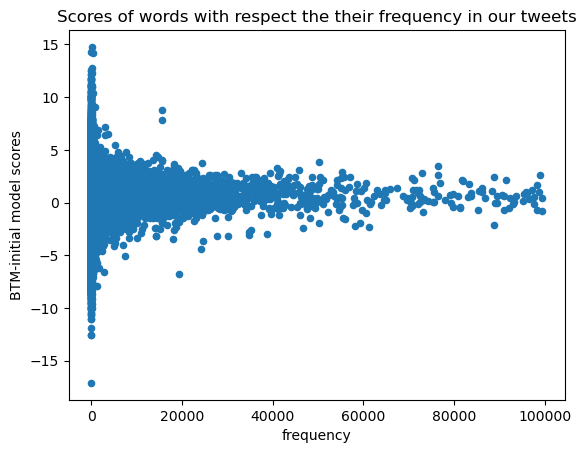

In [11]:
word_dict_freq.plot.scatter(x="frequency", y="init_scores")
plt.ylabel("BTM-initial model scores")
plt.title("Scores of words with respect the their frequency in our tweets")
plt.show()

In [12]:
word_dict_freq['init_scores'].describe()

count    1.468706e+06
mean     3.626570e-01
std      1.138052e+00
min     -1.710946e+01
25%     -2.913408e-01
50%      3.446435e-01
75%      1.018951e+00
max      1.475864e+01
Name: init_scores, dtype: float64

Let's check the words with the strongest significance.

In [13]:
word_dict_freq.sort_values(by='init_scores', ascending=False, inplace=True)
word_dict_freq.head(30)

,frequency,init_scores
"(sq, mi)",92,14.758640
"(kg, ha)",21,14.255180
"(sq, km)",301,14.158898
"(sq, ft)",246,12.749498
"(sq, feet)",16,12.560142
"(sq, kms)",41,12.498162
"(000, sq)",283,12.238315
"(50, kg)",16,12.156398
"(60, kg)",21,12.112294
"(kg, bomb)",13,11.791759


In [14]:
np.array(word_dict_freq.index)[0:200]

array([('sq', 'mi'), ('kg', 'ha'), ('sq', 'km'), ('sq', 'ft'),
       ('sq', 'feet'), ('sq', 'kms'), ('000', 'sq'), ('50', 'kg'),
       ('60', 'kg'), ('kg', 'bomb'), ('30', 'kg'), ('per', 'sq'),
       ('7653', 'kg'), ('100', 'kg'), ('000', 'kg'), ('20', 'kg'),
       ('million', 'sq'), ('s2', 'e8'), ('10', 'kg'), ('200k', 'sq'),
       ('kg', 'per'), ('per', 'kg'), ('700', 'sq'), ('sq', 'miles'),
       ('sq', 'mile'), ('kg', 'co2'), ('billion', 'kg'), ('per', 'm2'),
       ('kg', 'bags'), ('million', 'kg'), ('kg', 'by'), ('300', 'kg'),
       ('200', 'kg'), ('mm', 'mm'), ('kg', 'of'), ('of', 'kg'),
       ('000', 'km2'), ('kg', 'in'), ('bjp', 'mp'), ('kg', 'to'),
       ('to', 'kg'), ('by', 'm2'), ('kg', 'desciption'), ('40', 'cm'),
       ('kg', 'the'), ('m2', 'of'), ('one', 'kg'), ('mp', 'sue'),
       ('4g', 'kg'), ('22', 'kg'), ('and', 'kg'), ('kg', 'and'),
       ('at', 'kg'), ('450', 'kg'), ('50', 'cm'), ('kg', 'from'),
       ('mp', 'majid'), ('95', 'uv'), ('million', 'km2'),

Let's see what word appear to be the most neutral.

In [15]:
eps = 0.00005
word_dict_freq[(word_dict_freq['init_scores'] > 0 - eps) & (word_dict_freq['init_scores'] < 0 + eps)]

,frequency,init_scores
"(hotter, atmosphere)",15,0.000048
"(highest, costs)",24,0.000046
"(which, basically)",39,0.000045
"(that, seafood)",25,0.000044
"(and, karsten)",11,0.000044
...,...,...
"(and, elongating)",31,-0.000033
"(only, obstacle)",13,-0.000034
"(skipper, babar)",13,-0.000039
"(rising, wildfire)",13,-0.000042


Let's also check the words that should be avoided.

In [16]:
word_dict_freq.tail(30)

,frequency,init_scores
"(va, nc)",13,-9.231503
"(georgia, ga)",14,-9.316354
"(va, ap)",26,-9.411696
"(az, wx)",35,-9.464005
"(atlanta, ga)",67,-9.549057
"(amp, ga)",11,-9.561715
"(fi, fi)",12,-9.573945
"(pa, pa)",21,-9.584850
"(wi, fi)",82,-9.611166
"(ma, ga)",12,-9.662345


We notice that many of the most imprtnat words appeare only couple of times in the tweets and that they represent some abreviations. Let's fillter out the results once again, but now for the words that don't appear more than 700 times in the text of the tweets.

## Model Meta Data

In [17]:
model_meta = LogRegression(305)
model_meta.load_state_dict(torch.load("Models/btm-meta-time10%.pth"))
model_meta.eval()

for p in model_meta.parameters():
    print(p.shape)
    weights = p
    weights.requires_grad = False

torch.Size([1, 305])


In [18]:
# embeddings weights
word_weight = weights.numpy()[:, :300]

# weights for meta features in order "urls_count", "hashtags_count", "animated_gif_count", "video_count", "image"
meta_weight = weights.numpy()[:, 300:]
meta_weight

array([[-0.08203267, -0.01377606,  0.05208312,  0.03962353,  0.03828091]],
      dtype=float32)

**Here we can conclude that having an image or video (and also GIF but to lesser extent) attached with the tweet helps in drawing attention, while having urls and hastags negatively influences tweets' success.**

In [19]:
scores = word_weight @ (word_dict.iloc[:, :300]).T
word_dict['meta_scores'] = scores.squeeze(0)
word_dict.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,frequency,init_scores,meta_scores
"(might, evolve)",-0.002469,0.005903,0.035110,0.114040,-0.066777,-0.076330,-0.026234,-0.054957,0.025229,-0.053679,...,-0.000724,-0.001881,0.038340,0.026064,-0.022680,-0.017026,0.040640,21,-1.099682,-1.694227
"(nations, there)",-0.033756,-0.016510,-0.039934,0.012035,-0.063258,-0.027595,0.038091,-0.007862,-0.023769,-0.014519,...,-0.008202,0.004668,0.044757,-0.014797,0.083752,0.011240,-0.027933,50,0.910654,0.949017
"(geological, epoch)",0.060726,-0.026040,-0.026569,0.047821,0.016041,-0.056264,0.058897,-0.068911,0.000082,-0.011506,...,-0.010427,-0.028524,0.051610,0.047667,0.061328,-0.040683,-0.001338,45,1.725794,1.655121
"(global, from)",-0.032055,0.144442,0.001001,0.025292,-0.005327,0.009908,0.074127,0.014601,-0.018117,-0.022353,...,0.051705,0.009294,0.016534,-0.028809,0.046833,0.030390,0.049761,16,0.285278,0.001020
"(amp, secretary)",0.020415,-0.173545,0.082748,0.033836,0.013775,0.029854,0.032321,0.056168,-0.028470,-0.043725,...,-0.048814,0.003923,-0.101680,-0.114516,0.049802,-0.083444,-0.119704,31,-0.630693,-0.608500


Let's see if there is a difference in mean between scores.

In [20]:
(word_dict['meta_scores'] - word_dict['init_scores']).describe()

count    1.468775e+06
mean    -9.551127e-02
std      4.687632e-01
min     -7.887759e+00
25%     -3.180137e-01
50%     -7.138595e-02
75%      1.570777e-01
max      6.074849e+00
dtype: float64

We can see that there is not too significant change between `meta` and `init` scores, altough we can see that on average that scores got a little bit higher. 

Let's now check which words helped the most to tweets to be succesful. We will again filter out the words that only appear once (with the same reasoning behind the decision).

In [21]:
word_dict_freq = word_dict[(word_dict['frequency'] < 1e5)][["frequency", "init_scores", "meta_scores"]]
word_dict_freq.sort_values(by="meta_scores", inplace=True, ascending=False)
word_dict_freq["frequency"].describe()

count    1.468706e+06
mean     1.448520e+02
std      1.119635e+03
min      1.100000e+01
25%      1.500000e+01
50%      2.600000e+01
75%      6.400000e+01
max      9.939600e+04
Name: frequency, dtype: float64

In [22]:
word_dict_freq.head(30)

,frequency,init_scores,meta_scores
"(kg, ha)",21,14.255180,18.166178
"(sq, mi)",92,14.758640,17.547821
"(s2, e8)",17,11.116062,16.885477
"(sq, ft)",246,12.749498,15.148739
"(ha, ha)",959,9.043274,15.118123
"(sq, kms)",41,12.498162,14.897033
"(sq, feet)",16,12.560142,14.468279
"(sq, km)",301,14.158898,14.279612
"(000, sq)",283,12.238315,13.869247
"(per, m2)",12,10.644201,13.646464


In [23]:
np.array(word_dict_freq.index)[0:200]

array([('kg', 'ha'), ('sq', 'mi'), ('s2', 'e8'), ('sq', 'ft'),
       ('ha', 'ha'), ('sq', 'kms'), ('sq', 'feet'), ('sq', 'km'),
       ('000', 'sq'), ('per', 'm2'), ('7653', 'kg'), ('by', 'm2'),
       ('million', 'sq'), ('m2', 'of'), ('700', 'sq'), ('kg', 'bomb'),
       ('sq', 'miles'), ('60', 'kg'), ('per', 'sq'), ('50', 'kg'),
       ('sq', 'mile'), ('000', 'km2'), ('mp', 'majid'), ('s2', 'e9'),
       ('30', 'kg'), ('mp', 'sir'), ('200k', 'sq'), ('mp', 'sue'),
       ('million', 'km2'), ('100', 'kg'), ('000', 'kg'), ('tsk', 'tsk'),
       ('billion', 'kg'), ('m2', 'developments'), ('20', 'kg'),
       ('kg', 'bags'), ('bjp', 'mp'), ('4g', 'kg'), ('10', 'kg'),
       ('million', 'kg'), ('sh', 'sh'), ('km2', 'of'), ('kg', 'co2'),
       ('bs', 'bs'), ('ck', 'off'), ('km2', 'in'), ('km2', 'that'),
       ('300', 'kg'), ('tr', 'mp'), ('kg', 'per'), ('per', 'kg'),
       ('kg', 'by'), ('km2', 'and'), ('200', 'kg'), ('of', 'kg'),
       ('kg', 'of'), ('kg', 'in'), ('to', 'kg'), ('kg', 

Let's just look at the words that appear more frequently.

In [24]:
word_dict_freq.tail(30)

,frequency,init_scores,meta_scores
"(than, 1f)",14,-3.895394,-11.525758
"(greene, ga)",130,-9.998293,-11.534129
"(mieux, je)",194,-5.683896,-11.707096
"(ga, fl)",13,-10.677269,-11.708233
"(fl, ga)",15,-10.677269,-11.708233
"(ib, national)",22,-6.910271,-11.733063
"(news, qa)",13,-8.934662,-11.875534
"(qa, news)",21,-8.934662,-11.875534
"(mba, cpa)",12,-7.771989,-11.941749
"(2f, since)",12,-5.713773,-12.116658


## Author Latent Model

Finally, let's analyze the results of the general, Latent BTM model. In the first part we wish to see the general scores for the words based on the learned weights of the model.

In [25]:
# load the author embeddings necessary for the model
with open("data/authors_weights.pickle", "rb") as file:
    author_embeddings = pickle.load(file)
    
author_embeddings = pd.DataFrame.from_dict(author_embeddings, orient='index')
author_embeddings.head(3)

,0,1,2,3,4,5,6,7,8,9,...,295,296,297,298,299,300,301,302,303,304
22,-0.011832,0.000088,0.004434,0.038730,-0.047330,0.003657,0.012779,0.003983,-0.000961,-0.002555,...,0.014677,0.010975,0.123918,-0.006615,0.011359,0.923077,0.0,0.0,0.0,0.384615
224,-0.026187,-0.029001,0.015409,0.040204,-0.054712,-0.013778,0.028484,-0.008869,0.016860,-0.007510,...,0.013030,0.019806,0.111667,-0.002293,0.005656,0.550000,0.0,0.0,0.0,0.450000
246,-0.021350,-0.006799,0.015069,0.035720,-0.034636,-0.010558,0.014174,0.001210,0.000823,-0.000146,...,0.010463,0.003462,0.091501,-0.001289,0.010120,0.600000,0.0,0.0,0.0,0.600000


In [26]:
class BTMlatent(torch.nn.Module):
    def __init__(self, input_dim):
        super(BTMlatent, self).__init__()
        self.input_dim = input_dim
        self.latentW = torch.nn.Linear(input_dim, input_dim, bias=False)
        self.non_latentW = torch.nn.Linear(input_dim, 1, bias=False)
    
    def forward(self, x, ids, device="cpu"):
        author_embd = torch.from_numpy(author_embeddings.loc[ids].to_numpy()).to(device)
        return self.non_latentW(x) + (author_embd * self.latentW(x)).sum(dim=1, keepdim=True)
    
model_latent = BTMlatent(305)
model_latent.load_state_dict(torch.load("Models/btm-latent-time10%.pth"))

model_latent.eval()

params = []
for p in model_latent.parameters():
    p.requires_grad = False
    if p.shape[0] > 1:
        # weights for embeddings
        weights = p[:300, :300]
        params.append(weights)
        
    else:
        # weights for embeddings
        weights = p[:, :300]
        params.append(weights)
        print("Meta features:", "urls_count", "hashtags_count", "animated_gif_count", "video_count", "image")

        # weights for metadata
        print(p[0, 300:])

Meta features: urls_count hashtags_count animated_gif_count video_count image
tensor([-0.0103, -0.0013, -0.0067,  0.0018,  0.0176])


Let's get the average embedding for all authors.

In [27]:
avg_author_embedding = author_embeddings.iloc[:, :300].mean().to_numpy()
avg_author_embedding.shape

(300,)

In [28]:
# checking the shapes of parameters to recognize latent and non-latent weights
for p in params:
    print(p.shape)

torch.Size([300, 300])
torch.Size([1, 300])


In [29]:
scores = word_dict.iloc[:, :300] @ params[1].numpy().T + (
    avg_author_embedding * (word_dict.iloc[:, :300] @ params[0].numpy().T)).to_numpy().sum(axis=1, keepdims=True)
scores.shape

(1468775, 1)

Let's add the proper scores to our word dictonary.

In [30]:
word_dict['latent_scores'] = scores.squeeze(1)
word_dict.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,frequency,init_scores,meta_scores,latent_scores
"(more, migratory)",-0.011891,0.004752,0.033737,0.088514,-0.038102,-0.028592,-0.015962,-0.023646,0.003431,-0.025787,...,-0.015591,-0.005953,-0.018747,0.037757,0.031213,0.046338,82,-0.294693,-0.325761,-0.123981
"(driving, those)",-0.050199,0.002096,0.035282,0.083008,-0.052694,-0.005086,0.003694,-0.019012,0.001105,0.016284,...,0.002312,0.012776,0.032238,0.099926,0.039567,-0.002428,19,-0.063331,-0.290696,-0.523518
"(climatechange, investments)",-0.040019,-0.004593,0.016421,0.001559,-0.023137,-0.000793,0.020245,0.012130,0.012171,0.012947,...,0.024086,0.039059,0.012284,0.028742,0.025546,0.016529,31,-0.177507,-0.037958,-0.516483
"(preservation, or)",0.030927,-0.106522,0.063018,-0.068780,-0.075769,-0.096645,-0.003971,-0.060333,0.029268,-0.055709,...,0.124007,0.072111,0.092271,-0.064237,-0.106338,-0.025469,11,-0.197831,-0.250007,0.099758
"(wildfires, title)",-0.064118,0.006807,0.041302,0.042266,0.045251,0.020665,-0.017642,-0.026353,-0.003493,0.034682,...,0.022936,0.006366,-0.041698,0.036755,0.068409,0.059939,1647,1.248973,0.067720,-0.277700


Again, let's check the most significant words in for the successful reach out of a tweet.

In [31]:
word_dict_freq = word_dict[(word_dict['frequency'] < 1e5)][["frequency", "init_scores", "meta_scores", "latent_scores"]]
word_dict_freq.sort_values(by="latent_scores", inplace=True, ascending=False)
word_dict_freq["frequency"].describe()

count    1.468706e+06
mean     1.448520e+02
std      1.119635e+03
min      1.100000e+01
25%      1.500000e+01
50%      2.600000e+01
75%      6.400000e+01
max      9.939600e+04
Name: frequency, dtype: float64

In [32]:
word_dict_freq.head(30)

,frequency,init_scores,meta_scores,latent_scores
"(kg, ha)",21,14.255180,18.166178,15.735450
"(60, kg)",21,12.112294,13.081034,14.820167
"(50, kg)",16,12.156398,12.914154,14.783471
"(30, kg)",15,11.730497,12.631421,13.369265
"(200, kg)",18,10.404153,11.145656,13.297040
"(20, kg)",23,11.239622,12.071617,13.240559
"(kg, per)",19,11.031138,11.353369,13.055306
"(per, kg)",104,11.031138,11.353369,13.055306
"(10, kg)",32,11.114401,11.885205,12.980386
"(300, kg)",15,10.469088,11.367702,12.973493


In [33]:
np.array(word_dict_freq.index)[0:200]

array([('kg', 'ha'), ('60', 'kg'), ('50', 'kg'), ('30', 'kg'),
       ('200', 'kg'), ('20', 'kg'), ('kg', 'per'), ('per', 'kg'),
       ('10', 'kg'), ('300', 'kg'), ('7653', 'kg'), ('kg', 'bags'),
       ('000', 'kg'), ('kg', 'bomb'), ('100', 'kg'), ('450', 'kg'),
       ('ac', 'dc'), ('billion', 'kg'), ('kg', 'in'), ('lb', 'yr'),
       ('million', 'kg'), ('one', 'kg'), ('22', 'kg'), ('sh', 'sh'),
       ('kg', 'from'), ('kg', 'and'), ('and', 'kg'), ('to', 'kg'),
       ('kg', 'to'), ('of', 'kg'), ('kg', 'of'), ('per', 'm2'),
       ('kg', 'the'), ('kg', 'desciption'), ('at', 'kg'), ('kg', 'co2e'),
       ('per', 'lb'), ('4g', 'kg'), ('dc', 'has'), ('dc', 'oct'),
       ('dc', 'md'), ('dc', '34'), ('ha', 'ha'), ('000', 'lb'),
       ('outraged', 'dc'), ('dc', 'totem'), ('dc', 'no'), ('bjp', 'mp'),
       ('dc', 'cancels'), ('dc', 'power'), ('dc', 'never'), ('dc', 'was'),
       ('85', 'uv'), ('dc', 'after'), ('dc', 'usa'), ('kg', 'by'),
       ('harms', 'dc'), ('say', 'dc'), ('dc', 'd

Let's just look at the words that appear more frequently.

In [34]:
params_cuda = []
for p in params:
    params_cuda.append(p.to("cuda"))
    
words = torch.from_numpy(word_dict.iloc[:, :300].to_numpy()).to("cuda")

### Author specific words

Let's keep only the most significant authors that have the most followers, as we wish to consider only significant authors.

In [35]:
tweets = pd.read_pickle('data/tweets.pkl.bz2', compression='bz2')
authors_followers = tweets.groupby("author_id")['author_followers_count'].mean()
authors_followers.describe()

count    1.752495e+06
mean     7.669866e+03
std      2.803256e+05
min     -1.000000e+00
25%      9.600000e+01
50%      4.080000e+02
75%      1.471000e+03
max      1.333659e+08
Name: author_followers_count, dtype: float64

In [36]:
# this block takes ~15 minites to run
authors_top_words = {}
authors_diff_words = {}
for author, embeddings in tqdm(author_embeddings[author_embeddings.index.isin(
    authors_followers[(authors_followers >= 1000000)].index)].iterrows()):
    author_embd = torch.from_numpy(embeddings.iloc[:300].to_numpy()).to("cuda")
    scores = (words @ params_cuda[1].T + (
        author_embd * (words @ params_cuda[0].T)).sum(
        axis=1, keepdim=True)).to("cpu").numpy().squeeze(1)
    
    score_df = pd.DataFrame(scores,index = word_dict.index,columns =['score']).sort_values(by='score',ascending=False)[:20]
    diff = (scores - word_dict['latent_scores']).sort_values(ascending=False)[:20]
    authors_top_words[author] = list(zip(score_df.index,score_df['score']))
    authors_diff_words[author] = list(zip(diff.index,diff))

(len(authors_top_words),len(authors_diff_words))

0it [00:00, ?it/s]

(745, 745)

In [37]:
# sample some of the results we obtained
for key in sample(list(authors_top_words.keys()), 5):
    name = tweets[tweets['author_id'] == key]['author_name'].unique()
    value1 = authors_top_words[key]
    value2 = authors_diff_words[key]
    print('Author Name:  ' + name)
    print('Top ranking words: ' + ' '.join([str(w[0]) for w in value1])) 
    print('Top words that different from overall: ' + ' '.join([str(w[0]) for w in value2])) 
    print("=" * 100)

['Author Name:  Mike Bloomberg @MikeBloomberg']
Top ranking words: ('kg', 'ha') ('ac', 'dc') ('sh', 'sh') ('50', 'kg') ('60', 'kg') ('per', 'kg') ('kg', 'per') ('kg', 'bags') ('200', 'kg') ('7653', 'kg') ('kg', 'bomb') ('300', 'kg') ('30', 'kg') ('lb', 'yr') ('dc', 'md') ('20', 'kg') ('10', 'kg') ('000', 'kg') ('sh', 'ji') ('billion', 'kg')
Top words that different from overall: ('sh', 'sh') ('ico', 'bsc') ('va', 'wv') ('ac', 'dc') ('wv', 'epa') ('sh', 'ji') ('an', 'rv') ('bs', 'bs') ('wv', 'ag') ('sh', 'tty') ('dc', 'md') ('ban', 'ac') ('wv', 'amp') ('amp', 'wv') ('uq', 'news') ('gt', 'gt') ('uq', 'prof') ('uq', 'professor') ('cq', 'roll') ('gmo', 'ban')
['Author Name:  PTV News @PTVNewsOfficial']
Top ranking words: ('cc', 'cc') ('kg', 'ha') ('my', 'cc') ('4g', 'kg') ('ha', 'ha') ('50', 'kg') ('per', 'm2') ('my', 'mp') ('bjp', 'mp') ('sf', 'f1') ('60', 'kg') ('kg', 'bomb') ('uk', 'mp') ('mp', 'uk') ('kg', 'bags') ('da', 'da') ('dc', 'usa') ('my', 'ss') ('my', '4yo') ('my', 'da')
Top w

We can see clear patterns for some authors regarding their most importnat words: numbers, money, years, politics, etc.

### Audience specific words

We wish to group the authors according to audience and types of tweets that author writes. So let's see if we can categorize authors in some number of groups.

### PCA analysis

In [38]:
n_components = 3

pca = PCA(n_components=n_components)
components = pca.fit_transform(author_embeddings)

In [39]:
df_PCA = pd.DataFrame(components)
df_PCA['author'] = author_embeddings.index
df_PCA['index'] = df_PCA.index
df_PCA.head()

,0,1,2,author,index
0,0.082245,-0.385603,0.117040,22,0
1,0.288523,-0.245375,-0.169105,224,1
2,0.158013,-0.313258,-0.240158,246,2
3,-0.335412,0.388861,0.339591,985,3
4,-0.032193,-0.339725,0.162693,989,4


<AxesSubplot:xlabel='0', ylabel='1'>

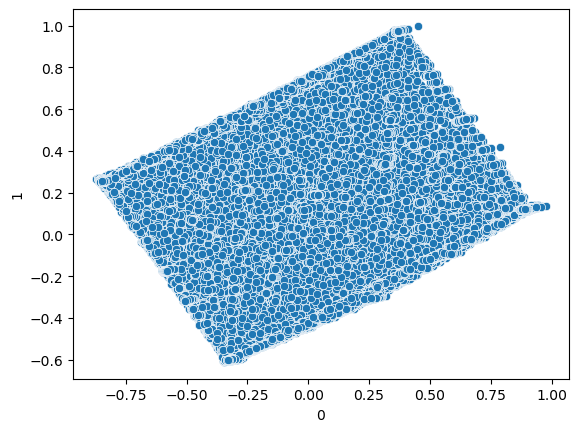

In [40]:

sns.scatterplot(data=df_PCA, x=0, y=1)

No obvious groups gotten from PCA.




Here we pick 4 authors(same with the word interpretation) that are furthest away from the center and each other (4 corner of our graph), assuming they write completly opposite tweets and to completly different audiences. 

In [41]:
author_ids = {'author1': 147750, 'author2': 122786, 'author3': 119708, 'author4': 88487}

df_PCA.iloc[list(author_ids.values())]

,0,1,2,author,index
147750,0.979184,0.137667,-0.255004,1109503615696363520,147750
122786,0.450360,0.998578,-0.190058,783317339416645632,122786
119708,-0.873979,0.263094,-0.119917,738787338281619456,119708
88487,-0.344247,-0.610767,-0.273937,1462634593,88487


In [42]:
audience_words = {}
for i in author_ids.keys():
    author_embd = torch.from_numpy(author_embeddings.iloc[author_ids[i]].iloc[:300].to_numpy()).to("cuda")
    scores = (words @ params_cuda[1].T + (
        author_embd * (words @ params_cuda[0].T)).sum(
        axis=1, keepdim=True)).to("cpu").numpy().squeeze(1)
    
    
    diff = (scores - word_dict['latent_scores']).sort_values(ascending=False)[:30]
    audience_words[author_ids[i]] = list(zip(diff.index,diff))
    
    word_dict[i] = scores
    
word_dict

,0,1,2,3,4,5,6,7,8,9,...,298,299,frequency,init_scores,meta_scores,latent_scores,author1,author2,author3,author4
"(the, business)",-0.034616,0.047232,-0.006303,0.049580,-0.037124,0.042071,0.037814,-0.002660,-0.001415,0.005219,...,-0.010705,0.003219,5564,-0.505434,-0.937905,-0.424574,-2.109289,1.108247,0.177783,-1.749581
"(business, of)",-0.008780,-0.083620,-0.035300,-0.204408,-0.019865,0.037216,0.004973,0.034216,-0.006140,0.004440,...,-0.080145,0.014343,1149,-0.178903,-0.773831,-0.221106,6.999029,4.046033,-1.107045,-5.159417
"(of, businesses)",-0.030593,-0.096034,-0.041795,-0.220057,-0.017181,0.040795,-0.013028,0.039685,-0.002545,-0.013907,...,-0.045575,0.029365,1043,-0.252661,-0.972023,-0.550058,6.068644,2.832102,-1.257705,-5.772312
"(businesses, is)",-0.079436,-0.106300,-0.058131,0.003559,-0.137406,0.012596,0.017852,0.060473,-0.008975,-0.037345,...,-0.088577,0.064825,161,0.414826,-0.361724,-0.710497,-3.821955,8.833285,-0.979039,-8.171777
"(is, climate)",-0.079481,-0.126187,-0.025456,0.006256,-0.124971,-0.048428,0.064270,0.075826,-0.008035,-0.026921,...,-0.061457,0.047905,33796,1.509396,1.474028,-0.046989,-8.941191,7.244850,0.357759,-3.936899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(woke, nhs)",-0.068883,-0.037040,0.114822,0.105979,-0.008778,0.078431,0.031850,0.224331,0.078812,-0.017359,...,0.002989,0.031574,18,0.889462,1.767082,1.804096,4.739927,1.686911,2.213927,14.622448
"(nhs, tributes)",-0.037381,0.045888,0.072474,0.033439,-0.030819,0.102649,0.089690,0.204645,0.052106,-0.081593,...,-0.028520,0.105315,18,0.044789,1.394331,1.148540,3.908871,1.221518,1.642805,12.288043
"(tributes, blm)",0.009524,0.051183,-0.028185,0.038329,-0.104098,0.081556,0.020536,-0.093857,-0.028959,0.011328,...,0.030013,0.124490,18,2.578357,3.791716,2.142308,-7.474121,-10.912200,-0.170043,7.834011
"(fist, salutes)",0.040817,-0.028446,0.025037,0.086051,-0.031896,-0.040128,0.031615,0.012818,-0.004115,0.121095,...,0.016505,-0.010251,18,2.486237,2.796025,1.856595,-0.215207,4.481445,2.076668,1.584560


In [43]:
# sample some of the results we obtained
for value in list(audience_words.values()):
    print(' '.join([str(w[0]) for w in value])) # names
    print("=" * 100)

('nj', 'nj') ('mcq', 'gk') ('nh', 'nh') ('gk', 'electrical') ('az', 'tx') ('title', 'gk') ('gk', 'generalawareness') ('gk', 'science') ('roe', 'vs') ('tx', 'co') ('ny', 'nj') ('nj', 'ny') ('or', 'tx') ('tx', 'or') ('ham', 'vs') ('tx', 'by') ('by', 'tx') ('maths', 'gk') ('week', 'dq') ('nj', 'pa') ('pa', 'nj') ('of', 'tx') ('by', 'nj') ('9x', 'cheaper') ('tx', 'amp') ('amp', 'tx') ('9x', 'more') ('at', 'gk') ('of', 'nj') ('xr', 'uk')
('az', 'tx') ('tx', 'co') ('tx', 'how') ('nj', 'nj') ('or', 'tx') ('tx', 'or') ('ga', 'ga') ('tx', 'gov') ('qc', 'qa') ('8bn', '3bn') ('if', 'tx') ('tx', 'oil') ('tx', 'is') ('am', 'fm') ('se', 'tx') ('vs', 'net') ('vs', 'how') ('3bn', '9bn') ('mcq', 'gk') ('va', 'nc') ('tx', 'can') ('change', 'vb') ('cnbc', 'tx') ('fl', 'tx') ('tx', 'fl') ('az', 'ga') ('be', 'vs') ('tx', 'khou') ('tx', 'not') ('tx', 'wants')
('cc', 'cc') ('1a', '2a') ('stage', '5e') ('5e', 'blood') ('5b', 'on') ('ep', 'ep') ('q3', '2020') ('on', 'fx') ('technology', 'q3') ('9c', 'on') ('13

In [44]:
word_dict_freq = word_dict[(word_dict['frequency'] < 1e5)]
np.array(word_dict_freq.sort_values(by='author1', ascending=False).index)[0:200]

array([('nj', 'nj'), ('week', 'dq'), ('az', 'tx'), ('sq', 'mi'),
       ('7653', 'kg'), ('lb', 'yr'), ('tx', 'co'), ('xr', 'uk'),
       ('gk', 'electrical'), ('mcq', 'gk'), ('tx', 'or'), ('or', 'tx'),
       ('ham', 'vs'), ('nh', 'nh'), ('gk', 'generalawareness'),
       ('gk', 'science'), ('title', 'gk'), ('roe', 'vs'), ('uk', 'uk'),
       ('lb', 'of'), ('tx', 'by'), ('by', 'tx'), ('of', 'tx'),
       ('7m', 'acres'), ('kg', 'dew'), ('xr', 'co'), ('nj', 'ny'),
       ('ny', 'nj'), ('sky', 'fm'), ('sq', 'ft'), ('amp', 'tx'),
       ('tx', 'amp'), ('by', '7m'), ('of', '7m'), ('tx', 'power'),
       ('kg', 'by'), ('kg', 'of'), ('of', 'kg'), ('nj', 'ct'),
       ('wv', 'vs'), ('866', 'lbs'), ('rx', 'co'), ('maths', 'gk'),
       ('9x', 'cheaper'), ('tx', 'fl'), ('fl', 'tx'), ('paso', 'tx'),
       ('amp', '7m'), ('tx', 'gov'), ('9x', 'more'), ('95', 'fm'),
       ('fm', '95'), ('tx', 'khou'), ('vs', 'ev'), ('ev', 'vs'),
       ('us', '888'), ('va', 'wv'), ('xr', 'or'), ('waco', 'tx'),
 

In [45]:
np.array(word_dict_freq.sort_values(by='author2', ascending=False).index)[0:200]

array([('az', 'tx'), ('8bn', '3bn'), ('tx', 'co'), ('va', 'wv'),
       ('tx', 'how'), ('3bn', '9bn'), ('va', 'nc'), ('tx', 'gov'),
       ('am', 'fm'), ('tx', 'or'), ('or', 'tx'), ('if', 'tx'),
       ('tx', 'oil'), ('change', 'vb'), ('va', 'sen'), ('va', 'gov'),
       ('wv', 'vs'), ('tx', 'is'), ('woo', 'woo'), ('se', 'tx'),
       ('bn', 'loss'), ('tx', 'fl'), ('fl', 'tx'), ('lb', 'yr'),
       ('sky', 'fm'), ('am', 'am'), ('how', 'adb'), ('7653', 'kg'),
       ('nj', 'nj'), ('tx', 'can'), ('6bn', 'yrs'), ('tx', 'not'),
       ('tx', 'power'), ('fm', 'or'), ('cnbc', 'tx'), ('waco', 'tx'),
       ('gbp', 'usd'), ('usd', 'gbp'), ('va', 'is'), ('tx', 'khou'),
       ('tx', 'asks'), ('az', 'co'), ('am', 'co'), ('vs', 'how'),
       ('adm', 'is'), ('va', 'who'), ('3bn', 'plan'), ('vs', 'net'),
       ('bn', 'yr'), ('tx', 'wants'), ('tx', 'this'), ('vb', 'on'),
       ('am', 'ct'), ('1bn', '2bn'), ('tx', 'you'), ('3bn', 'day'),
       ('nj', 'ct'), ('tx', 'for'), ('for', 'tx'), ('vs', 'c

In [46]:
np.array(word_dict_freq.sort_values(by='author3', ascending=False).index)[0:200]

array([('50', 'cm'), ('40', 'cm'), ('20', 'cm'), ('up', 'cm'),
       ('30', 'cm'), ('cc', 'cc'), ('15', 'cm'), ('10', 'cm'),
       ('cm', 'on'), ('ha', 'ha'), ('per', 'm2'), ('mp', 'ed'),
       ('60', '60'), ('19', 'cm'), ('21', 'cm'), ('25', 'cm'),
       ('50', '60'), ('cm', 'per'), ('61', 'cm'), ('50', '50'),
       ('ozone', 'o3'), ('60', '90'), ('water', 'hf'), ('billion', 'm3'),
       ('40', '60'), ('60', '40'), ('60', '70'), ('50', '90'),
       ('40', '50'), ('50', '70'), ('cm', 'are'), ('78', 'cm'),
       ('60', '80'), ('cc', '33'), ('million', 'm3'), ('50', '52'),
       ('26', 'cm'), ('cm', 'has'), ('20', '60'), ('70', '90'),
       ('50', '80'), ('cm', 'below'), ('up', '60'), ('cm', 'rise'),
       ('40', '40'), ('40', '70'), ('28', 'cm'), ('20', '50'),
       ('first', 'cm'), ('27', 'cm'), ('up', '50'), ('50', 'up'),
       ('cm', 'long'), ('30', '60'), ('80', '90'), ('50', '58'),
       ('the', 'sl'), ('cm', 'square'), ('52', '70'), ('40', '80'),
       ('51', '50'),

In [47]:
np.array(word_dict_freq.sort_values(by='author4', ascending=False).index)[0:200]

array([('uk', 'g7'), ('g7', 'uk'), ('da', 'da'), ('mm', 'mm'),
       ('uk', 'da'), ('cc', 'cc'), ('uk', 'uk'), ('g7', 'g20'),
       ('cm', 'sea'), ('uk', 'nz'), ('mp', 'uk'), ('uk', 'mp'),
       ('30', 'cm'), ('mp', 'ed'), ('20', 'cm'), ('19', 'cm'),
       ('up', 'cm'), ('15', 'cm'), ('un', 'g7'), ('21', 'cm'),
       ('ha', 'ha'), ('cm', 'lee'), ('mm', 'hg'), ('act', 'g7'),
       ('glasgow', 'hq'), ('hg', 'o2'), ('40', 'cm'), ('28', 'cm'),
       ('27', 'cm'), ('sq', 'ft'), ('hsbc', 'hq'), ('50', 'cm'),
       ('london', 'hq'), ('26', 'cm'), ('cm', 'sindh'), ('sl', 'journal'),
       ('10', 'cm'), ('manipur', 'cm'), ('usa', 'uk'), ('uk', 'usa'),
       ('germany', 'g7'), ('25', 'cm'), ('q3', 'uk'), ('cm', 'kejriwal'),
       ('canada', 'g7'), ('sq', 'mi'), ('bbc', 'r4'), ('clear', 'cm'),
       ('cm', 'square'), ('nyt', 'nyt'), ('44', 'mm'), ('g7', 'do'),
       ('first', 'cm'), ('da', 'un'), ('g7', 'govts'), ('imf', 'uk'),
       ('cm', 'rise'), ('cm', 'plants'), ('gsm', 'cc'), 

**Here we can infer that 4 authors do acutally have different perferred words. The same trends still exist among the four authors, such as there are many numbers, but one can see that there are still significant differences between these words. We can even infer from these words that the topics each of them focuses on are also different.**